# Web Parsing


## Introduction to Web Parsing

Web Parsing has 4 main steps

1. Create the URL that correspond to a search or a page you want
2. Get the content of the HTML page based on the URL
3. Parsing the content of the HTML page to retrieve the data you want
4. Storing / Processing this data

And about these steps:
* #1 is quite easy
* #2 could be complex if the page is protected by password or a mechanism to prevent web scrapping
* #3 is OK but you need to understand a bit about HTML
* #4 is just Python stuff

### Interactive Learning

A fun and interactive way to learn has been created here:

https://quizizz.com/join/lesson/621b9031fbcbe9001d6b30c2/start

This refers to the two following links introducing respectively HTML and Web Parsing:
* https://www.w3schools.com/html/html_intro.asp
* https://medium.com/opex-analytics/simple-web-scraping-in-python-90d6fddfaeca



### Example of simple Web Parsing

In this introduction, we will try to extract product names and prices from this website:
http://automationpractice.com/index.php

*NOTE: this is a dummy merchant website created to practice Web Test Automation and Web Scrapping.*

In [1]:
import requests

from bs4 import BeautifulSoup

url = "http://automationpractice.com/index.php"

# makes a request to the web page and gets its HTML
r = requests.get(url)

# stores the HTML page in 'soup', a BeautifulSoup object
soup = BeautifulSoup(r.content)


We can show the content stored in the "soup" with `soup.prettify()`

In [119]:
print(soup.prettify()[:1000] + "...")

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo" lang="en-gb">
 <!-- sp:feature:head-start -->
 <head>
  <script>
   var aPageStart = (new Date()).getTime();
  </script>
  <meta charset="utf-8"/>
  <!-- sp:end-feature:head-start -->
  <script type="text/javascript">
   var ue_t0=ue_t0||+new Date();
  </script>
  <!-- sp:feature:cs-optimization -->
  <meta content="on" http-equiv="x-dns-prefetch-control"/>
  <link href="https://images-eu.ssl-images-amazon.com" rel="dns-prefetch"/>
  <link href="https://m.media-amazon.com" rel="dns-prefetch"/>
  <link href="https://completion.amazon.com" rel="dns-prefetch"/>
  <!-- sp:end-feature:cs-optimization -->
  <script type="text/javascript">
   window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=f

By doing inspection of the page, we can notice that:
* All products are in `<div clas="product-container">`
* The name of the product is (inside the product) in `<a class="product-name">`
* The price of the product is (inside the product) in `<span class="price product-price">` (so searching for either class `price` or `product-price`)

In BeautifulSoup, we will use:
* `.find_all(...)` to search all products
* `.find(...)` to search an element
* `class_="..."` to specify the class

**IMPORTANT**:
Note the underscore `_`  after "class" (`class_`) because `class` is a keyword used in Python language.

So to get products names and prices, we could something like this:

In [3]:
list_products = {}

for product in soup.find_all("div", class_="product-container"):
    name = product.find("a", class_="product-name").text.strip()
    price = product.find("span", class_="price").text.strip()
    list_products[name] = price

list_products

{'Faded Short Sleeve T-shirts': '$16.51',
 'Blouse': '$27.00',
 'Printed Dress': '$50.99',
 'Printed Summer Dress': '$30.50',
 'Printed Chiffon Dress': '$16.40'}

... BUT we only get 5 products because some products have the same name: so it's better to store all data in a list of Tuples for example

In [4]:
list_products_tuples = []

for product in soup.find_all("div", class_="product-container"):
    name = product.find("a", class_="product-name").text.strip()
    price = product.find("span", class_="price").text.strip()
    list_products_tuples.append((name, price))  # double parentheses here because we need a tuple

list_products_tuples

[('Faded Short Sleeve T-shirts', '$16.51'),
 ('Blouse', '$27.00'),
 ('Printed Dress', '$26.00'),
 ('Printed Dress', '$50.99'),
 ('Printed Summer Dress', '$28.98'),
 ('Printed Summer Dress', '$30.50'),
 ('Printed Chiffon Dress', '$16.40'),
 ('Printed Chiffon Dress', '$16.40'),
 ('Faded Short Sleeve T-shirts', '$16.51'),
 ('Blouse', '$27.00'),
 ('Printed Summer Dress', '$28.98'),
 ('Printed Dress', '$26.00'),
 ('Printed Summer Dress', '$30.50'),
 ('Printed Dress', '$50.99')]

Usually we will use `pandas`, which is THE library for data science.

The data is stored in a `DataFrame`, which is the equivalent of an Excel Table.
The usual way to create a Data Frame is:
* from an Excel or .csv file if we have one
* from a list of tuples, that will correspond to the values in columns
* from a list of dictionaries, that will create the needed columns and their headers

Here, we could use a list of tuples we just created.

In [5]:
import pandas as pd

df = pd.DataFrame(list_products_tuples, columns=["Product", "Price"])
df

,Product,Price
0,Faded Short Sleeve T-shirts,$16.51
1,Blouse,$27.00
2,Printed Dress,$26.00
3,Printed Dress,$50.99
4,Printed Summer Dress,$28.98
5,Printed Summer Dress,$30.50
6,Printed Chiffon Dress,$16.40
7,Printed Chiffon Dress,$16.40
8,Faded Short Sleeve T-shirts,$16.51
9,Blouse,$27.00


Or we could use a list of dictionaries with 2 keys:
* `"Product"`
* `"Price"`

NOTE: we need to remove the `$` from the price and convert to a float!

... and why not using list Comprehension :)

In [6]:
import pandas as pd

list_products_dict = [
    {
        "Product": p.find("a", class_="product-name").text.strip(),
        "Price": float(p.find("span", class_="price").text.strip().strip("$")),
    }
    for p in soup.find_all("div", class_="product-container")
]
df = pd.DataFrame(list_products_dict)
df


,Product,Price
0,Faded Short Sleeve T-shirts,16.51
1,Blouse,27.00
2,Printed Dress,26.00
3,Printed Dress,50.99
4,Printed Summer Dress,28.98
5,Printed Summer Dress,30.50
6,Printed Chiffon Dress,16.40
7,Printed Chiffon Dress,16.40
8,Faded Short Sleeve T-shirts,16.51
9,Blouse,27.00


We can check the type of data with `.dtypes`, to verify that prices are floats.

In [7]:
df.dtypes

Product     object
Price      float64
dtype: object

... so now we can draw some graph, get the average, maximum, ...

In [8]:
df.describe()

,Price
count,14.000000
mean,28.054286
std,11.144574
min,16.400000
25%,18.882500
50%,27.000000
75%,30.120000
max,50.990000


<AxesSubplot:ylabel='Frequency'>

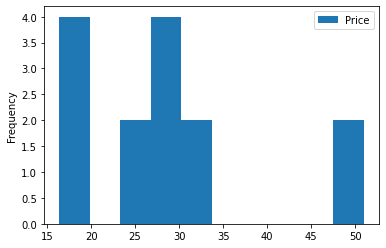

In [9]:
df.plot.hist()

## Project - Part 1: WEB SCRAPPING OF PRODUCTS

We will create a small web parsing project that will retrieve prices from different merchant websites:
* JD.com (Chinese)
* Amazon.co.uk (UK)
* NewEgg.com (USA)



### JD.com

#### Getting URL for JD

If you do a research of `Yoga mat` in JD.com, we get the following URL in the address bar:

`https://search.jd.com/Search?keyword=yoga%20mat&enc=utf-8&wq=yoga%20mat&pvid=dac61387e9f2464c9ec209af976dc84e`


Often the URL can be simplified a bit by removing part of attributes: the following URL is still working:

`https://search.jd.com/Search?keyword=yoga%20mat`

Therefore, the URL would be:

`"https://search.jd.com/Search?keyword="` + **search keywords** (using `%20` for spaces)


The transformation of spaces to `%20` could be either done by string manipulation (`.replace(" ", "%20")`) or more safely by using the `urllib` library.

In [10]:
from urllib.parse import quote

quote("yoga mat")

'yoga%20mat'

In [11]:
def get_jd_url(keywords):
    """Return the URL for a JD search based on a keyword"""
    return f"https://search.jd.com/Search?keyword={quote(keywords)}"

get_jd_url("yoga mat")

'https://search.jd.com/Search?keyword=yoga%20mat'

🎀BONUS🎀

A Search has actually several pages: you could modify the function to add an argument with the page number of the search result.

JD is using a strange system: an attribute `page` with a value that corresponds to `3` for page 2, `5` for page 3, ...

```python
def get_jd_url(keywords, page_number=None):
    if page_number is None:
        return f"https://search.jd.com/Search?keyword={quote(keywords)}"
    else:
        return f"https://search.jd.com/Search?keyword={quote(keywords)}&page={2 * page_number - 1}"
```

You then have to get the maximum number of pages when parsing the first page, and do a loop for all the pages in order to get all the products.

For purpose of simplicity, we will stick to the results of the first page.

#### Getting HTML from JD

Let's try to use `requests` like we did before to retrieve the HTML content.

In [12]:
def jd_2_soup(keywords):
    """Get the BeautifulSoup object for a JD search"""
    url = get_jd_url(keywords)
    resp = requests.get(url)
    return BeautifulSoup(resp.content)

soup = jd_2_soup("yoga mat")
print(soup.prettify())

<html>
 <head>
  <script>
   window.location.href='https://passport.jd.com/uc/login'
  </script>
 </head>
</html>


We can see that the content is not what we except (the the content of a `<script>`).

Probably, JD is using some script to block parsing of data.

An alternative is to use the Python Library `requests_html` (that is not provided in Python by default and needs to be installed).

This library is more powerful but is a bit more complicated to use: we need to create a Session to parse the code.

More information about this library here: https://pypi.org/project/requests-html/

In [120]:
from requests_html import HTMLSession

def jd_2_soup(keywords):
    """Get the BeautifulSoup object for a JD search"""
    url = get_jd_url(keywords)
    session = HTMLSession()
    resp = session.get(url)
    return BeautifulSoup(resp.html.html, "html.parser")

soup = jd_2_soup("yoga mat")
print(soup.prettify()[:1000] + "...")

<!DOCTYPE html>
<head>
 <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
 <meta content="webkit" name="renderer"/>
 <meta content="max-age=300" http-equiv="Cache-Control">
  <link href="//search.jd.com" rel="dns-prefetch"/>
  <link href="//item.jd.com" rel="dns-prefetch"/>
  <link href="//list.jd.com" rel="dns-prefetch"/>
  <link href="//p.3.cn" rel="dns-prefetch"/>
  <link href="//misc.360buyimg.com" rel="dns-prefetch"/>
  <link href="//nfa.jd.com" rel="dns-prefetch"/>
  <link href="//d.jd.com" rel="dns-prefetch"/>
  <link href="//img12.360buyimg.com" rel="dns-prefetch"/>
  <link href="//img13.360buyimg.com" rel="dns-prefetch"/>
  <link href="//static.360buyimg.com" rel="dns-prefetch"/>
  <link href="//csc.jd.com" rel="dns-prefetch"/>
  <link href="//mercury.jd.com" rel="dns-prefetch"/>
  <link href="//x.jd.com" rel="dns-prefetch"/>
  <link href="//wl.jd.com" rel="dns-prefetch"/>
  <title>
   yoga mat - 商品搜索 -

#### Parsing products of JD from HTML


##### Getting the information about product

An inspection of the page (i.e. the code) with JD results give the following result:

![Inspection of JD](images/inspect_JD.png "HTML elements for JD product")

To summarize:
* products: `<div>` with class=`gl-i-wrap`
* picture: `<img>` and then get the `src`
* price: `<div>` with class=`p-price`, and then look for `<i>` (or `strong` if we want the currency)
* name: `<div>` with class=`p-name` and then look for `title` attribute or maybe we could just try to get the `.text`

In [101]:
soup_jd = jd_2_soup("yoga mat")
products_jd = soup_jd.find_all("div", class_="gl-i-wrap")
print(f"Found {len(products_jd)} products")

Found 30 products


In [102]:
prod = products_jd[0]
name = prod.find("div", class_="p-name").text.strip()
price = float(prod.find("div", class_="p-price").find("i").text.strip())

print(f"""\
Name: {name}
Price: {price}
""")

Name: Yottoy 天然橡胶5mm瑜伽垫防滑女男初学者加厚加宽加长瑜珈垫健身垫女士
【遇见春天】瑜伽活动专场，甄选好物，等你来抢~戳这里查看
Price: 148.0



The image is a bit more complex because has an attribute `source-data-lazy-image` that does some transformation (`src` is changed to something else)

In [48]:
image = prod.find("div", {"class": "p-img"}).find("img")  # no "text" here because we search the attribute with URL
image.attrs["src"]

KeyError: 'src'

Let's forget about the picture then.

---


NOTE: If you are curious, you could check the attributes by printing `image` and seeing there is an attribute `data-lazy-img` that returns the following URL:
`//img10.360buyimg.com/n7/jfs/t1/195838/14/20844/72023/612dc968E548e1fd9/1a89ed81613ef06d.jpg`. Just add `http:` in front and you get your picture URL:


`http://img10.360buyimg.com/n7/jfs/t1/195838/14/20844/72023/612dc968E548e1fd9/1a89ed81613ef06d.jpg`

![Picture of Result](http://img10.360buyimg.com/n7/jfs/t1/195838/14/20844/72023/612dc968E548e1fd9/1a89ed81613ef06d.jpg "The result picture")


##### Transforming into a DataFrame

We can now put everything in a DataFrame (let's stick to name and price).

In [103]:
def get_df_jd(keywords):
    """Get a dataframe for the results of a JD search"""
    soup = jd_2_soup("yoga mat")
    products = soup.find_all("div", {"class": "gl-i-wrap"})
    data_products = [

        {
            "name": p.find("div", class_="p-name").text.strip(),
            "price": float(p.find("div", class_="p-price").find("i").text.strip()),
            "image": "http:" + p.find("div", class_="p-img").find("img").attrs["data-lazy-img"].strip(),
        }
        for p in products
    ]
    return pd.DataFrame(data_products)

df = get_df_jd("yoga mat")
print(df.describe())
df

            price
count   30.000000
mean   149.600000
std     27.704848
min     95.000000
25%    133.250000
50%    155.000000
75%    166.750000
max    199.000000


,name,price,image
0,Yottoy 天然橡胶5mm瑜伽垫防滑女男初学者加厚加宽加长瑜珈垫健身垫女士\n【遇见春天】...,148.0,http://img10.360buyimg.com/n7/jfs/t1/195838/14...
1,爱心东东\t\n‼lulu·lemon青色鸟瑜伽垫旗舰同款YOGAMAT瑜伽垫女专用初学者加...,109.0,http://img14.360buyimg.com/n7/jfs/t1/220359/31...
2,爱心东东\t\n‼lulu·lemon青色鸟瑜伽垫旗舰同款YOGAMAT瑜伽垫女专用初学者加...,101.0,http://img12.360buyimg.com/n7/jfs/t1/221802/39...
3,爱心东东\nYOGAMAT瑜伽垫女tpe80CM加宽加厚健身垫初学者三件套毯 皓月灰+爵士黑...,160.0,http://img12.360buyimg.com/n7/jfs/t1/120008/26...
4,YOGAMAT瑜伽垫女tpe80CM加宽加厚健身垫初学者三件套毯 曼陀罗花抹茶绿+坚毅黑【8...,140.0,http://img10.360buyimg.com/n7/jfs/t1/206704/8/...
5,YOGAMAT瑜伽垫女tpe80CM加宽加厚健身垫初学者三件套毯 碳素灰+冰蓝【80cm宽】...,130.0,http://img10.360buyimg.com/n7/jfs/t1/174821/30...
6,YOGAMAT瑜伽垫女tpe80CM加宽加厚健身垫初学者三件套毯 曼陀罗花雾霾蓝+藏蓝【80...,140.0,http://img12.360buyimg.com/n7/jfs/t1/210964/14...
7,YOGAMAT瑜伽垫女tpe80CM加宽加厚健身垫初学者三件套毯 曼陀罗花雾霾蓝+藏蓝【80...,169.0,http://img10.360buyimg.com/n7/jfs/t1/165540/1/...
8,瑜伽垫 天然橡胶瑜伽垫 5mm加厚防滑初学者 健身垫 带体位线YOGA MAT 淡墨灰-带体...,199.0,http://img10.360buyimg.com/n7/jfs/t1/182970/38...
9,YOGAMAT瑜伽垫tpe男女初学者舞蹈加厚加宽加长防滑健身垫家用地垫 浅灰-黛蓝【61cm...,115.0,http://img11.360buyimg.com/n7/jfs/t1/158094/25...


### Amazon UK

*Note: not Amazon USA, because it is protected against web scrapping*


We are now scrapping products with their prices from https://www.amazon.co.uk

#### Getting URL from Amazon US


Look at how we defined a function to get URL for a JD search and adapt to Amazon UK.

Note: Amazon is using `+` to separate keywords instead of `%20` in its website.

... but if you use `%20` it is actually working as well.

You can try: [https://www.amazon.co.uk/s?k=yoga%20mat](https://www.amazon.co.uk/s?k=yoga%20mat)   [**spoiler alert**: it is replaced automatically]

In [74]:
def get_amazon_url(keywords):
    """Return the URL for an Amazon search based on a keyword"""
    return f"https://..."  # TODO: replace the ... by the correct content

get_amazon_url("yoga mat")

'https://www.amazon.co.uk/s?k=yoga%20mat'

#### Getting HTML from Amazon UK

In [126]:
from requests_html import HTMLSession

# It is almost a copy paste of the JD equivalent function

def amazon_2_soup(keywords):
    """Get the BeautifulSoup object for a Amazon UK search"""
    url = get_amazon_url(keywords)
    session = HTMLSession()
    resp = session.get(url)
    return BeautifulSoup(resp.html.html, "html.parser")

soup = amazon_2_soup("yoga mat")
print(soup.prettify()[:300] + "\n......\n" + soup.prettify()[-300:])

<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo" lang="en-gb">
 <!-- sp:feature:head-start -->
 <head>
  <script>
   var aPageStart = (new Date()).getTime();
  </script>
  <meta charset="utf-8"/>
  <!-- sp:end-feature:head-start -->
  <script type="text/javascript">
   var ue_t0=ue_t0||+
......
 && ue.count && ue.count('CSMLibrarySize', 80956)
   </script>
  </div>
 </body>
</html>
<!--       _
       .__(.)< (MEOW)
        \___)   
 ~~~~~~~~~~~~~~~~~~-->
<!-- sp:eh:ttjenL6L8DRTMz+S627gFEd4b5OYYqkitIa9xbEtCA1gC5vL3Nj9x941LhuMVwUjrR48qy5MmjJwu3av1tapnJ3i2mmCPoR2fgGfeFOI4oOiN8JhsMjnkg== -->



#### Parsing products of Amazon UK from HTML

When doing inspection, we can notice that all results are inside a `<div class="sg-col-inner"...>`.

However, if we look at the first similar result, this is what we get:

In [88]:
soup = amazon_2_soup("yoga mat")
first_prod = soup.find("div", class_="sg-col-inner")
first_prod.prettify()

'<div class="sg-col-inner">\n <div class="a-section a-spacing-small a-spacing-top-small">\n  <span>\n   1-48 of 286 results for\n  </span>\n  <span>\n  </span>\n  <span class="a-color-state a-text-bold">\n   "yoga mat"\n  </span>\n </div>\n</div>'

So basically, this is a block at the top with the total number of results:

![Picture of 1st "Result"](images/first_result.png "The total number of results")

... by looking a bit further, we can see that the all the results are inside a `<div class="s-matching-dir">`:

We will first get this element, and then search inside for all the `<div class="sg-col-inner"...>`.

In [90]:
soup = amazon_2_soup("yoga mat")
products = soup.find("div", class_="s-matching-dir").find_all("div", class_="sg-col-inner")
print(f"Found {len(products)} products")

Found 87 products


We can check the code of first result:

(there are some link to pictures: just copy-paste in a browser to verify that it is a picture of a yoga mat:
`https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL320_.jpg`
)

In [105]:
products[0].prettify()[:1000]

'<div class="sg-col-inner">\n <div id="s-skipLinkTargetForMainSearchResults" tabindex="-1">\n </div>\n <span class="rush-component" data-component-type="s-top-slot">\n </span>\n <span class="rush-component" data-component-type="s-top-banner">\n </span>\n <span class="rush-component s-latency-cf-section" data-component-type="s-search-results">\n  <div class="s-result-list s-search-results sg-row">\n   <div class="s-border-top-overlap aok-hidden">\n   </div>\n  </div>\n  <div class="s-main-slot s-result-list s-search-results sg-row">\n   <img alt="" class="s-prefetch-image" src="https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL320_.jpg" srcset="https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL320_.jpg 1x, https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL480_QL65_.jpg 1.5x, https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL640_QL65_.jpg 2x, https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL800_QL65_.jpg 2.5x, https://m.media-amazon.com/images/I/71pSktIgxSL._AC_UL960

##### Parsing of Product in Amazon

The code of a product result is the following

![Code of a product](images/amazon_uk_products.png "A product")

You now have to extract:
1. The name
2. The price

💡TIP: for the price, take care of the following:
* Don't get several prices (we can see that it appears twice)
* Remove the currency with `.strip("£")`
* Convert to float to store a number and not a string

In [110]:
prod = products[0]
name = ...
price = ...
# TODO: Implement to get the name and price of product (remove the ... and replace with correct code)

print(f"""\
Name: {name}
Price: {price}
""")

Name: Ellipsis
Price: Ellipsis



##### Transform into a DataFrame

Just like we did for JD, create a function to get a DataFrame for Amazon by re-using the code we just got to retrieve a product name and price (you can ignore the picture unless you feel bold enough to try).

🛎️IMPORTANT: the list of products might contain items without a price: you can filter by adding a condition `if prod.find("span", class_="a-price")` when doing a loop on all products `prod` of the list of products

In [117]:
# TODO: Replace ... by correct code

def get_df_amazon(keywords):
    """Get a dataframe for the results of an Amazon search"""
    soup = ...
    products = ...
    data_products = [
        {
            "name": ...,
            "price": ...,
        }
        for p in products
        if ...
    ]
    return pd.DataFrame(data_products)

df = get_df_amazon("yoga mat")
print(df.describe())
df

TypeError: 'ellipsis' object is not iterable

### NewEgg

[OPTIONAL CHALLENGE]

Now that you are familiar with the basics of Web Scrapping from a merchant site, try doing the same with NewEgg:

https://www.newegg.com/

The purpose is to create a function `get_df_newegg` that create a DataFrame based on keywords.

Good luck!!

💡#1:  For the prices, some prices are missing, so you can filter with this: `if prod.find("li", class_="price-current").text`

💡#2: The prices contain currency but also a number or offer and a strange character `"–"` (a sort of long hyphen): you can use the following function to extract the float value from the price as a string:
```python
def get_newegg_price(price_current):
    """Process the price of a result (string) and return the string"""
    import re
    return float(re.sub(r'.*?([\d\.]+).*', r'\1', price_current))
```


# THE END